In [50]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline 

In [51]:
# read in all the words
words = open("names.txt", "r").read().splitlines()

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [52]:
import random 
random.seed(42)
random.shuffle(words)

In [53]:
# build the dataset
block_size = (
    8  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [54]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()] )

........ --> e
.......e --> b
......eb --> r
.....ebr --> i
....ebri --> m
...ebrim --> a
..ebrima --> .
........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j
.......j --> h
......jh --> e
.....jhe --> n
....jhen --> e
...jhene --> .


In [55]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # paramters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffer (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim=(0, 1)
            xmean = x.mean(dim=dim, keepdim=True)  # batch mean
            xvar = x.var(dim=dim, keepdim=True, unbiased=True)  # batch variance
            # data is a sample from a population so using unbiased (divide by n-1)
            # Using x as sample shrinks variance, so we compensate by dividing by N−1 instead of N.
            # This correction is called Bessel’s correction.
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar - self.eps)  # normalise to unit variance
        self.out = self.gamma * xhat + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Embedding:
    def __init__(self, num_embedding, embedding_dim):
        self.weight = torch.randn((num_embedding, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n , C*self.n)
        if x.shape[1] == 1: # if (B, 1, C*n) --> return (B, C*n)
            x = x.squeeze(dim=1)
        self.out = x
        return self.out

    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # get parameter of all layer and stretch them out in a list
        return [p for layer in self.layers for p in layer.parameters()]

In [56]:
torch.manual_seed(42)

In [57]:
n_embd = 24  # the dimensionality of the character embedding vectors
n_hidden = 128  # the number of neurons in the hidden layer of the MLP

model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        # first merge
        FlattenConsecutive(2),
        Linear(n_embd * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        # second merge
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        # third merge
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),

        Linear(n_hidden, vocab_size),
    ]
)

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1  # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [58]:
# e = torch.randn(32, 4, 68)

# emean = e.mean(0, keepdim=True)  # (1, 1, 68)
# evar = e.var(0, keepdim=True)  # (1, 1, 68)

# ehat = (e - emean) / torch.sqrt(evar + 1e-5)  # (32, 4, 68)

# ehat.shape
# torch.Size([32, 4, 68])

# emean.shape
# torch.Size([1, 4, 68])

# SOLUTION : mean over dim=(0,1)
# emean = e.mean((0, 1), keepdim=True)  # (1, 1, 68)
# evar = e.var((0, 1), keepdim=True)  # (1, 1, 68)

# emean.shape
# torch.Size([1, 1, 68])

In [59]:
# ix = torch.randint(0, Xtr.shape[0], (4,))  # batch of 4 examples
# Xb, Yb = Xtr[ix], Ytr[ix]
# logits = model(Xb)
# print(Xb.shape)

In [60]:
# for layer in model.layers:
#     print(layer.__class__.__name__, ':', tuple(layer.out.shape))

In [61]:
# model.layers[0].out.shape # output of embedding layer
# torch.Size([4, 8, 10])

In [62]:
# model.layers[1].out.shape  # output of flatten layer
# torch.Size([4, 4, 20])

In [63]:
# model.layers[2].out.shape  # output of linear layer
# torch.Size([4, 4, 68])

In [64]:
# list(range(10))[::2] # even
# [0, 2, 4, 6, 8]

In [65]:
# list(range(10))[1::2] # odd
# [1, 3, 5, 7, 9]

In [66]:
# e = torch.randn(4, 8, 10) # goal: want this to be (4, 4, 20) where consecutive 10-d vector get concatenated
# explicit_concat = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
# explicit_concat.shape
# torch.Size([4, 4, 20])

In [67]:
# (e.view(4,4,20) == explicit_concat).all()
# tensor(True)

### performance log 

#### 3 char context, 200 hidden neuron, 12k params
- train 2.0593066215515137
- val 2.1068429946899414

#### 8 char context, 200 hidden neuron, 12k params
- train 1.9220352172851562
- val 2.0287797451019287

#### 8 char context, 12k params, new wavenet architecture
- train 1.9131152629852295
- val 2.0219650268554688

####  8 char context, 76k params, new wavenet architecture
- train 1.7669241428375244
- val 1.9844722747802734


#### rmr no residual and conv

In [68]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.3088
  10000/ 200000: 2.4522
  20000/ 200000: 2.1598
  30000/ 200000: 2.6425
  40000/ 200000: 1.8248
  50000/ 200000: 2.5059
  60000/ 200000: 2.1407
  70000/ 200000: 1.8226
  80000/ 200000: 2.0718
  90000/ 200000: 1.7831
 100000/ 200000: 2.0265
 110000/ 200000: 2.0255
 120000/ 200000: 1.8355
 130000/ 200000: 1.8886
 140000/ 200000: 1.7411
 150000/ 200000: 1.9732
 160000/ 200000: 1.7233
 170000/ 200000: 1.9166
 180000/ 200000: 2.3648
 190000/ 200000: 1.7625


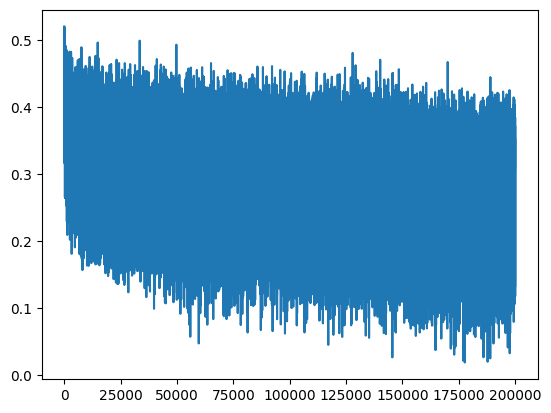

In [69]:
plt.plot(lossi)

In [70]:
len(lossi)

200000

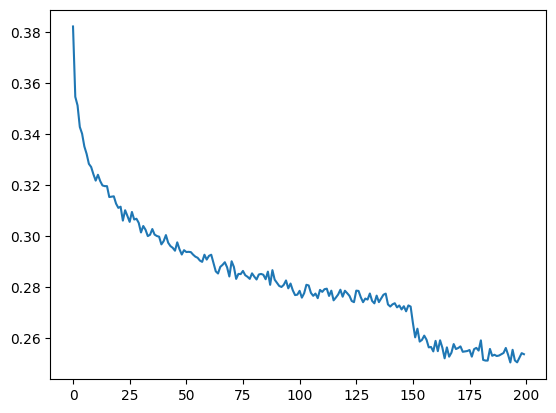

In [71]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))
# shows decay

In [72]:
for layer in model.layers:
    layer.training = False

In [73]:
# evaluate the loss
@torch.no_grad()  # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

# old benchmark 
# train 2.0593066215515137
# val 2.1068429946899414

train 1.7669241428375244
val 1.9844722747802734


In [74]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...

    while True:
        # forward pass through the neural net
        logits = model(torch.tensor([context]))  # (1, block_size, n_embd)
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    # decode and print the generated word
    print("".join(itos[i] for i in out))

abeljah.
ottavious.
santi.
emmelynn.
aisam.
aisabrie.
jerina.
mannsley.
teau.
aranza.
raniyah.
layveon.
zayell.
cassidine.
remita.
niyecha.
jaylene.
abyan.
aubreana.
ilyra.


# Next time

In [78]:
Xtr[[7+1]].shape

torch.Size([1, 8])

In [77]:
Xtr[8].shape

torch.Size([8])

In [79]:
for x, y in zip(Xtr[7:15], Ytr[7:15]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

........ --> h
.......h --> i
......hi --> l
.....hil --> t
....hilt --> o
...hilto --> n
..hilton --> .
........ --> j


In [80]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape
# torch.Size([1, 27])

torch.Size([1, 27])

In [81]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
    logits[i] = model(Xtr[[7 + i]])
logits.shape
# torch.Size([8, 27])

torch.Size([8, 27])

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space